# CNN + MaxPool
Use the model of CNN_262, our best MCC yet.

Instead of canonical, use all.

Instead of -1, use GMM.

In [12]:
from datetime import datetime
print(datetime.now())

2023-03-21 17:04:36.025777


In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [14]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [15]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.all_lncRNA_transcripts.csv'

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [18]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    #cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    #cnn.add(cnn3_layer)
    #cnn.add(cnn4_layer)
    #cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [19]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 17:04:37.956939
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4997, 4)           1028      
                                                                 
 conv1d_4 (Conv1D)           (None, 4990, 64)          2112      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1246, 64)         0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 79744)             0         
                                                                 
 dropout_4 (Dropout)         (None, 79744)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 79745     
                           

## Training

In [20]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [21]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 17:04:38.136330
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_lncRNA_transcripts.csv
Loaded 19789 sequences.
2023-03-21 17:05:09.465727

Training # 1 1
2023-03-21 17:05:09.467395
2023-03-21 17:05:09.467740
Discriminator is GMM
Means [-1.6758399311172867, 0.1319803166777027]
Variances [2.46099075 1.41731718]
Priors [0.49004469 0.50995531]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 8950:7109 55.73%
Computed class weights: {0: 1.1294837529891686, 1: 0.8971508379888268}
Valid 1:0 2347:1383 62.92%
FIT
2023-03-21 17:05:22.328380


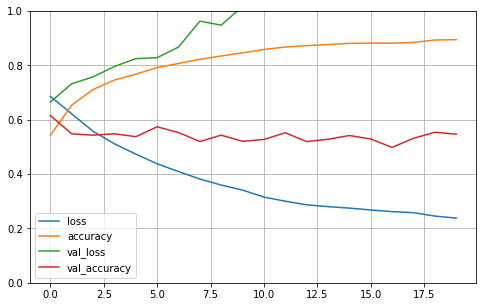


2023-03-21 17:07:46.740397

Testing # 1 1
2023-03-21 17:07:46.740833
2023-03-21 17:07:46.740872
PREDICT
2023-03-21 17:07:47.716561
Test 1:0 2347:1383 62.92%
Predict 1:0 2236:1494 59.95%
Test sizes (3730, 4997) (3730,)
Range of scores: 3.5386404e-06 to 0.9999993
Score threshold 0.5
Confusion matrix
 [[ 593  790]
 [ 901 1446]]
Normalized matrix
 [[0.15898123 0.21179625]
 [0.24155496 0.38766756]]


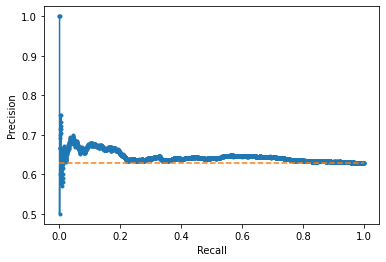

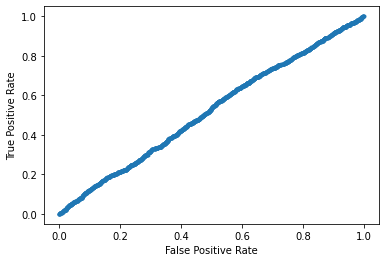

Accuracy: 54.66% Precision: 64.67% Recall: 61.61%
F1: 63.10% MCC: 0.0442
AUPRC: 64.48% AUROC: 52.07%
 accuracy [54.66487935656836]
 precision [64.6690518783542]
 recall [61.6105666808692]
 F1 [63.102771110626236]
 MCC [0.04424303876423689]
 AUPRC [64.47905868512865]
 AUROC [52.07048828661133]
2023-03-21 17:07:49.066398

Training # 1 2
2023-03-21 17:07:49.066512
2023-03-21 17:07:49.066551
Discriminator is GMM
Means [-0.03397415782309363, -1.826020454979901]
Variances [1.45934423 2.76217046]
Priors [0.58572998 0.41427002]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10877:4923 68.84%
Computed class weights: {0: 1.6047125736339631, 1: 0.7263032086053139}
Valid 1:0 2739:1250 68.66%
FIT
2023-03-21 17:08:01.806295


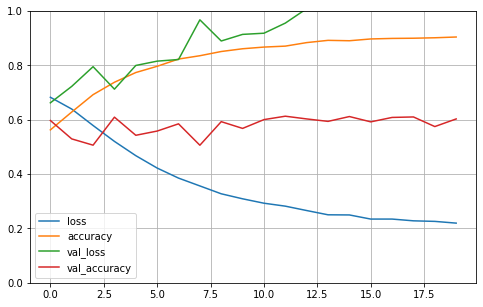


2023-03-21 17:09:39.901349

Testing # 1 2
2023-03-21 17:09:39.901450
2023-03-21 17:09:39.901486
PREDICT
2023-03-21 17:09:40.916485
Test 1:0 2739:1250 68.66%
Predict 1:0 2669:1320 66.91%
Test sizes (3989, 4997) (3989,)
Range of scores: 6.630179e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 493  757]
 [ 827 1912]]
Normalized matrix
 [[0.12358987 0.18977187]
 [0.20732013 0.47931812]]


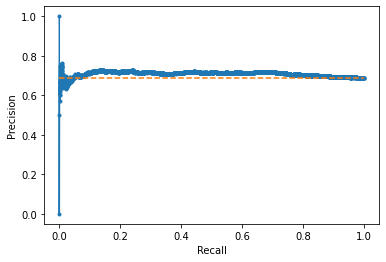

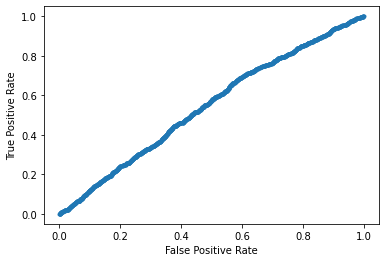

Accuracy: 60.29% Precision: 71.64% Recall: 69.81%
F1: 70.71% MCC: 0.0912
AUPRC: 70.86% AUROC: 54.56%
 accuracy [60.29079969917272]
 precision [71.6373173473211]
 recall [69.80649872216136]
 F1 [70.71005917159763]
 MCC [0.09115218511978443]
 AUPRC [70.85891503139877]
 AUROC [54.555706462212484]
2023-03-21 17:09:42.102341

Training # 1 3
2023-03-21 17:09:42.103307
2023-03-21 17:09:42.103354
Discriminator is GMM
Means [-1.8006680083401607, 0.053831580061722305]
Variances [2.5060403  1.42148915]
Priors [0.43194415 0.56805585]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10604:5567 65.57%
Computed class weights: {0: 1.4523980599964075, 1: 0.7624952847981894}
Valid 1:0 2302:1316 63.63%
FIT
2023-03-21 17:09:57.706872


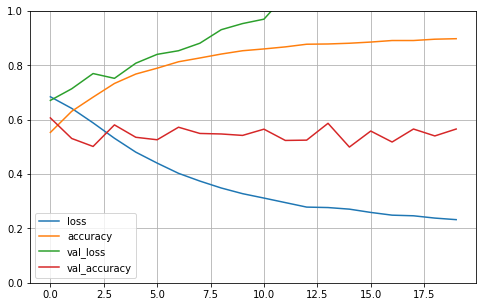


2023-03-21 17:12:22.192528

Testing # 1 3
2023-03-21 17:12:22.192803
2023-03-21 17:12:22.192850
PREDICT
2023-03-21 17:12:23.128927
Test 1:0 2302:1316 63.63%
Predict 1:0 2445:1173 67.58%
Test sizes (3618, 4997) (3618,)
Range of scores: 1.0639404e-05 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[ 459  857]
 [ 714 1588]]
Normalized matrix
 [[0.12686567 0.2368712 ]
 [0.1973466  0.43891653]]


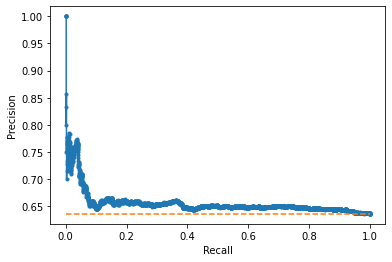

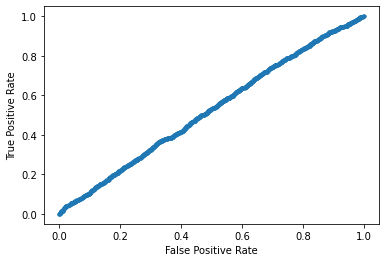

Accuracy: 56.58% Precision: 64.95% Recall: 68.98%
F1: 66.91% MCC: 0.0397
AUPRC: 65.61% AUROC: 52.47%
 accuracy [56.57822001105583]
 precision [64.94887525562372]
 recall [68.98349261511729]
 F1 [66.90541394564988]
 MCC [0.03969122908878359]
 AUPRC [65.60638684733179]
 AUROC [52.466617504535506]
2023-03-21 17:12:24.715830

Training # 1 4
2023-03-21 17:12:24.716763
2023-03-21 17:12:24.716819
Discriminator is GMM
Means [0.006516733898399464, -1.8741662760461324]
Variances [1.370483   2.56395909]
Priors [0.57233985 0.42766015]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10387:5526 65.27%
Computed class weights: {0: 1.4398298950416215, 1: 0.7660055839029556}
Valid 1:0 2737:1139 70.61%
FIT
2023-03-21 17:12:39.649420


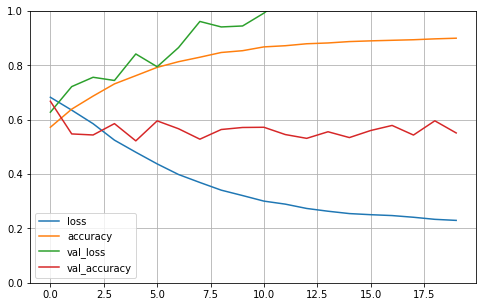


2023-03-21 17:15:03.539091

Testing # 1 4
2023-03-21 17:15:03.539193
2023-03-21 17:15:03.539230
PREDICT
2023-03-21 17:15:04.524760
Test 1:0 2737:1139 70.61%
Predict 1:0 2456:1420 63.36%
Test sizes (3876, 4997) (3876,)
Range of scores: 3.440381e-07 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 410  729]
 [1010 1727]]
Normalized matrix
 [[0.10577915 0.1880805 ]
 [0.26057792 0.44556244]]


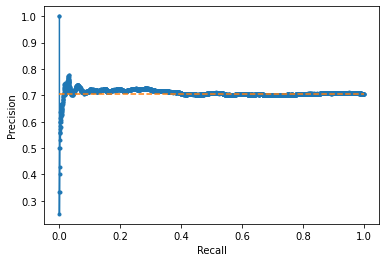

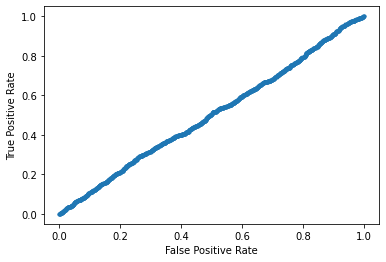

Accuracy: 55.13% Precision: 70.32% Recall: 63.10%
F1: 66.51% MCC: -0.0086
AUPRC: 70.95% AUROC: 50.28%
 accuracy [55.13415892672858]
 precision [70.31758957654723]
 recall [63.09828279137742]
 F1 [66.51261313306374]
 MCC [-0.008558534294493943]
 AUPRC [70.95074189580663]
 AUROC [50.277984232590626]
2023-03-21 17:15:07.322024

Training # 1 5
2023-03-21 17:15:07.322235
2023-03-21 17:15:07.322290
Discriminator is GMM
Means [0.024018451612978452, -1.9649463605484332]
Variances [1.36245906 2.32069659]
Priors [0.627736 0.372264]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10819:4394 71.12%
Computed class weights: {0: 1.7311106053709604, 1: 0.7030686754783252}
Valid 1:0 3079:1497 67.29%
FIT
2023-03-21 17:15:22.196533


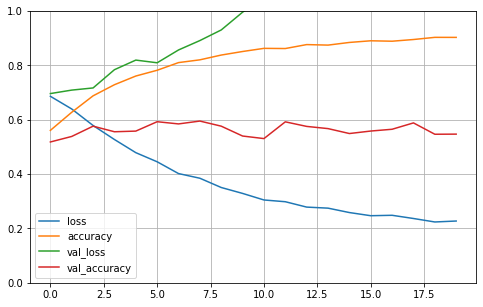


2023-03-21 17:17:46.386645

Testing # 1 5
2023-03-21 17:17:46.386769
2023-03-21 17:17:46.386810
PREDICT
2023-03-21 17:17:47.574630
Test 1:0 3079:1497 67.29%
Predict 1:0 2950:1626 64.47%
Test sizes (4576, 4997) (4576,)
Range of scores: 2.7809398e-07 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 525  972]
 [1101 1978]]
Normalized matrix
 [[0.11472902 0.21241259]
 [0.24060315 0.43225524]]


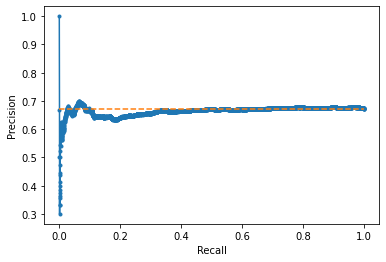

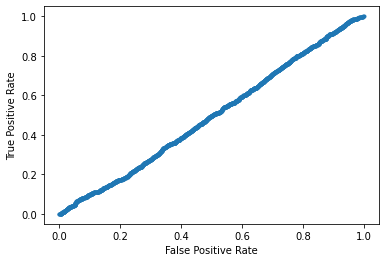

Accuracy: 54.70% Precision: 67.05% Recall: 64.24%
F1: 65.62% MCC: -0.0067
AUPRC: 66.50% AUROC: 49.53%
 accuracy [54.69842657342657]
 precision [67.05084745762711]
 recall [64.24163689509581]
 F1 [65.61618842262399]
 MCC [-0.006746422528118915]
 AUPRC [66.49715557137792]
 AUROC [49.53039130116897]
2023-03-21 17:17:49.109350

Training # 2 1
2023-03-21 17:17:49.109506
2023-03-21 17:17:49.109551
Discriminator is GMM
Means [-0.0015806145690699274, -1.8802551862435997]
Variances [1.47007051 2.67238466]
Priors [0.58518419 0.41481581]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10336:5012 67.34%
Computed class weights: {0: 1.531125299281724, 1: 0.742453560371517}
Valid 1:0 3165:1276 71.27%
FIT
2023-03-21 17:18:02.051017


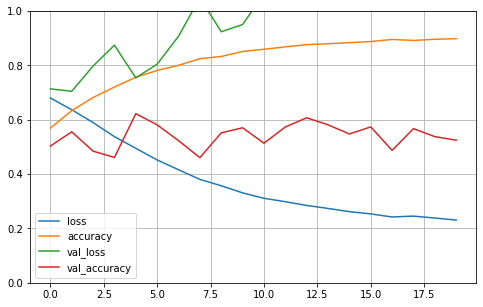


2023-03-21 17:20:25.853726

Testing # 2 1
2023-03-21 17:20:25.854034
2023-03-21 17:20:25.854073
PREDICT
2023-03-21 17:20:26.971796
Test 1:0 3165:1276 71.27%
Predict 1:0 2536:1905 57.10%
Test sizes (4441, 4997) (4441,)
Range of scores: 3.7319698e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 535  741]
 [1370 1795]]
Normalized matrix
 [[0.12046836 0.16685431]
 [0.30848908 0.40418825]]


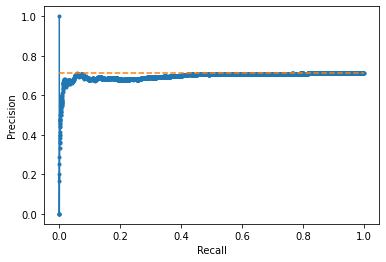

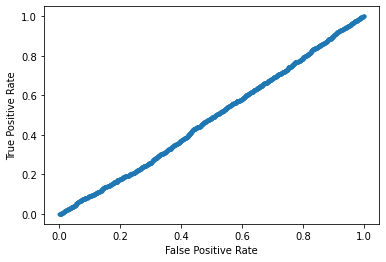

Accuracy: 52.47% Precision: 70.78% Recall: 56.71%
F1: 62.97% MCC: -0.0124
AUPRC: 69.78% AUROC: 48.37%
 accuracy [52.46566088718757]
 precision [70.7807570977918]
 recall [56.71406003159558]
 F1 [62.971408524820205]
 MCC [-0.012416601179720821]
 AUPRC [69.77871142422521]
 AUROC [48.37088403234832]
2023-03-21 17:20:28.543133

Training # 2 2
2023-03-21 17:20:28.543305
2023-03-21 17:20:28.543352
Discriminator is GMM
Means [0.06565424729214618, -1.797417641192013]
Variances [1.34439582 2.546908  ]
Priors [0.5758194 0.4241806]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10264:5437 65.37%
Computed class weights: {0: 1.4439028876218503, 1: 0.7648577552611068}
Valid 1:0 2690:1398 65.80%
FIT
2023-03-21 17:20:40.990898


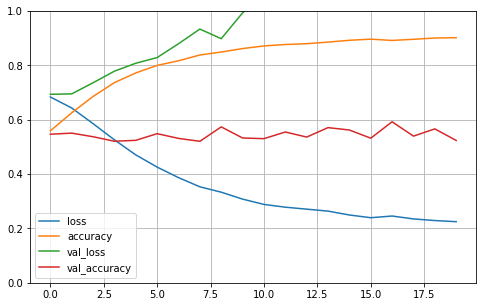


2023-03-21 17:23:04.764808

Testing # 2 2
2023-03-21 17:23:04.764907
2023-03-21 17:23:04.764945
PREDICT
2023-03-21 17:23:05.898958
Test 1:0 2690:1398 65.80%
Predict 1:0 2113:1975 51.69%
Test sizes (4088, 4997) (4088,)
Range of scores: 6.5832194e-07 to 0.9999982
Score threshold 0.5
Confusion matrix
 [[ 713  685]
 [1262 1428]]
Normalized matrix
 [[0.17441292 0.1675636 ]
 [0.30870841 0.34931507]]


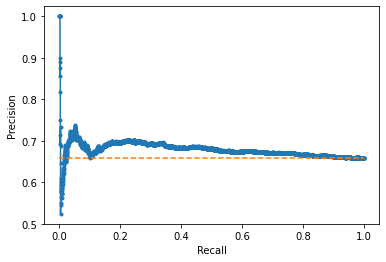

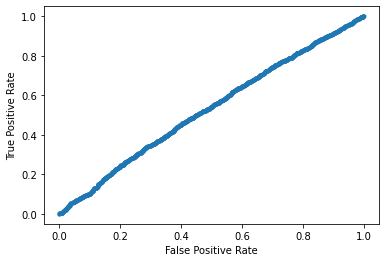

Accuracy: 52.37% Precision: 67.58% Recall: 53.09%
F1: 59.46% MCC: 0.0388
AUPRC: 67.91% AUROC: 53.17%
 accuracy [52.37279843444227]
 precision [67.58163748225272]
 recall [53.08550185873606]
 F1 [59.4628357276702]
 MCC [0.03879661984708676]
 AUPRC [67.91353221056025]
 AUROC [53.169543851811675]
2023-03-21 17:23:08.398379

Training # 2 3
2023-03-21 17:23:08.398578
2023-03-21 17:23:08.398627
Discriminator is GMM
Means [0.22989711327670082, -1.7440377148623039]
Variances [1.29042425 2.02126817]
Priors [0.52688413 0.47311587]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 9032:6979 56.41%
Computed class weights: {0: 1.147084109471271, 1: 0.8863485385296723}
Valid 1:0 2090:1688 55.32%
FIT
2023-03-21 17:23:18.826619


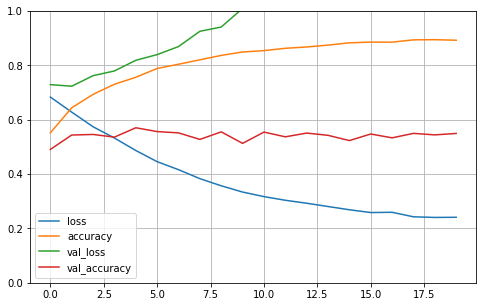


2023-03-21 17:25:43.223062

Testing # 2 3
2023-03-21 17:25:43.224360
2023-03-21 17:25:43.224648
PREDICT
2023-03-21 17:25:44.370837
Test 1:0 2090:1688 55.32%
Predict 1:0 2696:1082 71.36%
Test sizes (3778, 4997) (3778,)
Range of scores: 1.7209246e-08 to 0.9999993
Score threshold 0.5
Confusion matrix
 [[ 534 1154]
 [ 548 1542]]
Normalized matrix
 [[0.14134463 0.30545262]
 [0.14505029 0.40815246]]


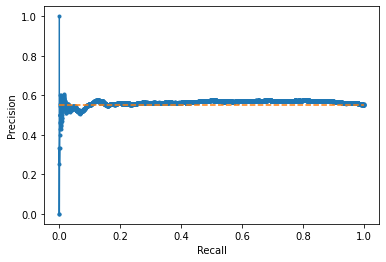

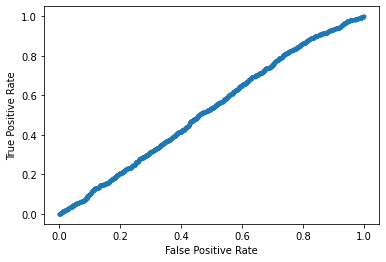

Accuracy: 54.95% Precision: 57.20% Recall: 73.78%
F1: 64.44% MCC: 0.0596
AUPRC: 56.29% AUROC: 52.78%
 accuracy [54.94970884065643]
 precision [57.195845697329375]
 recall [73.7799043062201]
 F1 [64.43794400334309]
 MCC [0.059550070170656194]
 AUPRC [56.29009215401872]
 AUROC [52.779314723689886]
2023-03-21 17:25:45.732354

Training # 2 4
2023-03-21 17:25:45.733301
2023-03-21 17:25:45.733345
Discriminator is GMM
Means [-0.03389314433770613, -1.8457535357861536]
Variances [1.40824418 2.81492043]
Priors [0.60060276 0.39939724]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 11609:4618 71.54%
Computed class weights: {0: 1.756929406669554, 1: 0.6988974071840813}
Valid 1:0 2434:1128 68.33%
FIT
2023-03-21 17:25:59.034491


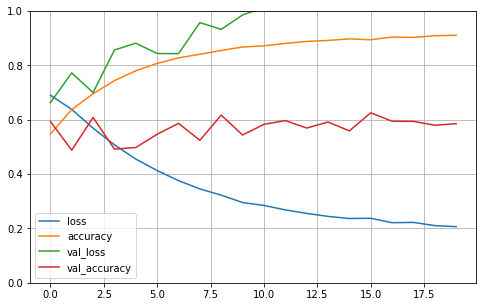


2023-03-21 17:27:40.242884

Testing # 2 4
2023-03-21 17:27:40.251694
2023-03-21 17:27:40.251737
PREDICT
2023-03-21 17:27:41.947291
Test 1:0 2434:1128 68.33%
Predict 1:0 2499:1063 70.16%
Test sizes (3562, 4997) (3562,)
Range of scores: 4.5517903e-05 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[ 357  771]
 [ 706 1728]]
Normalized matrix
 [[0.10022459 0.21645143]
 [0.19820326 0.48512072]]


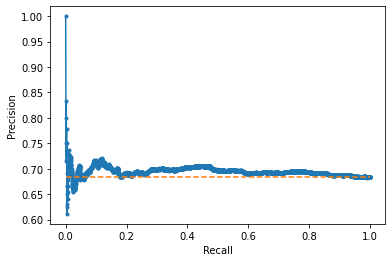

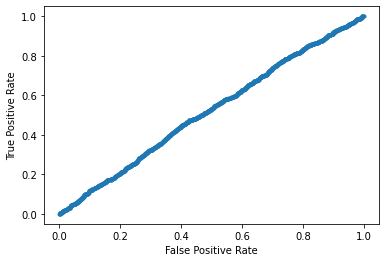

Accuracy: 58.53% Precision: 69.15% Recall: 70.99%
F1: 70.06% MCC: 0.0269
AUPRC: 69.48% AUROC: 52.16%
 accuracy [58.53453116226839]
 precision [69.14765906362545]
 recall [70.99424815119146]
 F1 [70.05878775592946]
 MCC [0.026871538116025512]
 AUPRC [69.4810034137469]
 AUROC [52.15991174088125]
2023-03-21 17:27:43.751026

Training # 2 5
2023-03-21 17:27:43.751739
2023-03-21 17:27:43.753339
Discriminator is GMM
Means [-0.07278927654138478, -1.8356883998549485]
Variances [1.49474544 2.66546851]
Priors [0.57216767 0.42783233]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10665:5204 67.21%
Computed class weights: {0: 1.5246925441967718, 1: 0.7439756211908111}
Valid 1:0 2838:1082 72.40%
FIT
2023-03-21 17:27:56.526394


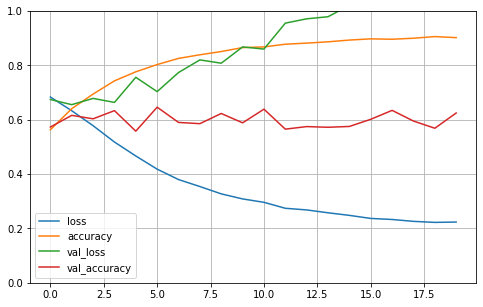


2023-03-21 17:30:20.570236

Testing # 2 5
2023-03-21 17:30:20.570348
2023-03-21 17:30:20.570386
PREDICT
2023-03-21 17:30:21.572230
Test 1:0 2838:1082 72.40%
Predict 1:0 2897:1023 73.90%
Test sizes (3920, 4997) (3920,)
Range of scores: 2.0901496e-06 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 317  765]
 [ 706 2132]]
Normalized matrix
 [[0.08086735 0.19515306]
 [0.18010204 0.54387755]]


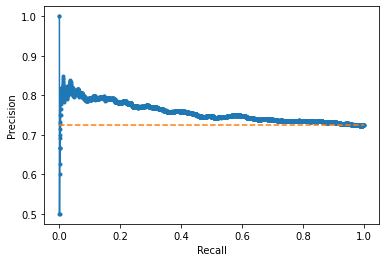

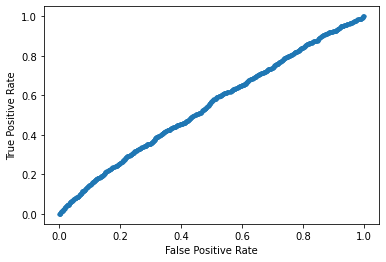

Accuracy: 62.47% Precision: 73.59% Recall: 75.12%
F1: 74.35% MCC: 0.0450
AUPRC: 75.65% AUROC: 54.60%
 accuracy [62.474489795918366]
 precision [73.59337245426303]
 recall [75.12332628611699]
 F1 [74.35047951176983]
 MCC [0.04500085285169107]
 AUPRC [75.65471267189788]
 AUROC [54.597006040285066]
2023-03-21 17:30:22.725621


In [22]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [23]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 56.22% std 3.29
 precision mean 67.69% std 4.67
 recall mean 65.74% std 7.27
 F1 mean 66.41% std 4.35
 MCC mean 0.03% std 0.03
 AUPRC mean 67.75% std 5.14
 AUROC mean 52.00% std 2.05
 accuracy [[54.66487935656836], [60.29079969917272], [56.57822001105583], [55.13415892672858], [54.69842657342657], [52.46566088718757], [52.37279843444227], [54.94970884065643], [58.53453116226839], [62.474489795918366]]
 precision [[64.6690518783542], [71.6373173473211], [64.94887525562372], [70.31758957654723], [67.05084745762711], [70.7807570977918], [67.58163748225272], [57.195845697329375], [69.14765906362545], [73.59337245426303]]
 recall [[61.6105666808692], [69.80649872216136], [68.98349261511729], [63.09828279137742], [64.24163689509581], [56.71406003159558], [53.08550185873606], [73.7799043062201], [70.99424815119146], [75.12332628611699]]
 F1 [[63.102771110626236], [70.71005917159763], [66.90541394564988], [66.51261313306374], [65.61618842262399], [62.971408524820205], [59.462835